# Calculation of similarity curves - prediction of developmental stages

This notebook demonstrates the use of Twin Network for calculation of similarity curves. This means, similarities between one test image and images from a reference image time series are assessed. Calculation of similarities with a reference image series can be used to predict the corresponding developmental stage of the test image.

# Table of Contents
* [General](#first-bullet)
* [Load paths](#second-bullet)
* [Load model](#third-bullet)
* [Calculate embeddings](#fourth-bullet)
* [Calculate similarities](#fifth-bullet)
* [(Optional) Save similarities](#sixth-bullet)
* [Plot similarities as similarity curve](#seventh-bullet)
* [Plot similarities as developmental trajectory](#eigth-bullet)
* [Compare similarities of embryos at different acquisition timepoints](#ninth-bullet)

## General <a class="anchor" id="first-bullet"></a>

General imports and class definitions

In [1]:
%load_ext autoreload
%autoreload 2

Load paths from config file

In [2]:
from twinnet_tools.tnconfig import ProjectConfig

config = ProjectConfig("twinnet_config")

ProjectConfig: C:\TwinNet-main\code\Scripts\twinnet_config\Windows\config.json


In [3]:
dir_root_data = config.json["dir_data"]
dir_root_scripts = config.json["dir_scripts"]
paths_anchor = config.json["paths_json_reference_src_imgs_1"]
path_model_zebrafish = config.json["dir_model_zebrafish_original"]

config_paths_script = config.json["Similarities_developmental_stages"]
path_src_data_test = config_paths_script["dir_data_src"]
path_dst = config_paths_script["dir_data_dst"]


Import Python packages

In [4]:
import glob
import matplotlib as mpl
import pandas as pd
from pathlib import Path
import sys

sys.path.append(dir_root_scripts)
from twinnet_tools.tngeneral import TNToolsGeneral
from twinnet_tools.tninference import TNToolsEmbeddings
from twinnet_tools.tninference import TNToolsSimilarities
from twinnet_tools.tnmodel import TNToolsNetwork
from twinnet_tools.tnplot import TNToolsPlot

Prepare class instances

In [5]:
tools_general = TNToolsGeneral()
tools_embeddings = TNToolsEmbeddings(size_img=224,
                                     size_img_min=300)
tools_model = TNToolsNetwork()
tools_similarities = TNToolsSimilarities()
tools_plot = TNToolsPlot()

Adjust matplotlib parameters to save plots as .svg files.

In [6]:
new_rc_params = {'text.usetex': False,
                'svg.fonttype': 'none'}
mpl.rcParams.update(new_rc_params)

## Load paths <a class="anchor" id="second-bullet"></a>

Load reference data paths

In [7]:
paths_anchor_1_relative = tools_general.fn_json_load(paths_anchor["json_anchor_1"])
paths_anchor_2_relative = tools_general.fn_json_load(paths_anchor["json_anchor_2"])
paths_anchor_3_relative = tools_general.fn_json_load(paths_anchor["json_anchor_3"])

paths_anchor_1 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_1_relative]
paths_anchor_2 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_2_relative]
paths_anchor_3 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_3_relative]


Specify path to test data

In [8]:
paths_src_data_test_imgs = sorted(glob.glob(f'{path_src_data_test}/*.tif'))
print((path_src_data_test))

C:/TwinNet-main/data/twinnet_data/data_test_similarities_developmental_stages/--E000--C012--PO01


Specifiy directory to save output files to

In [9]:
dir_dst_similarities = f"{path_dst}/similarities"

dir_dst_similarities_path = Path( dir_dst_similarities )

dir_dst_similarities_path.mkdir(parents=True, exist_ok=True)


## Load model <a class="anchor" id="third-bullet"></a>

In [10]:
tn_model_embedding = tools_model.tn_embedding_load(path_model_zebrafish)

## Calculate embeddings <a class="anchor" id="fourth-bullet"></a>

Calculate reference embeddings. Please note that we calculate three sets of embeddings, as we have three sets of reference images.

In [11]:
embeddings_reference_1 = tools_embeddings.list_to_embeddings(paths_anchor_1,
                                                             tn_model_embedding)
embeddings_reference_2 = tools_embeddings.list_to_embeddings(paths_anchor_2,
                                                             tn_model_embedding)
embeddings_reference_3 = tools_embeddings.list_to_embeddings(paths_anchor_3,
                                                             tn_model_embedding)

[DONE][Embeddings] 0018/0018                      
[DONE][Embeddings] 0018/0018                      
[DONE][Embeddings] 0018/0018                      


Calculate test embeddings

In [12]:
embeddings_test = tools_embeddings.list_to_embeddings(paths_src_data_test_imgs, tn_model_embedding)

[DONE][Embeddings] 0021/0021                      


## Calculate similarities <a class="anchor" id="fifth-bullet"></a>

Similarities are calculated for each timepoint in the set of test images. Thus, for each acquisition timepoint, similarities to three reference datasets are calculated. The values for these similarities are stored per timepoint as a pandas.core.frame.DataFrame, and sorted to a dictionary (named 'similarities_test') by acquisition timepoints. Starting with index 0 for the first acquisition timepoint.

In [13]:
similarities_test = tools_similarities.cosine_similarities_reference(embeddings_reference_1,
                                                                     embeddings_reference_2,
                                                                     embeddings_reference_3,
                                                                     embeddings_test)

## (Optional) Save similarities <a class="anchor" id="sixth-bullet"></a>

Save similarities to directory specified by variable "dir_dst_similarities".

In [14]:
tools_similarities.fn_similarities_save(similarities_test,
                                        dir_dst_similarities,
                                        signature='0082--C012--PO01--E000_')

Load similarities

In [15]:
list_paths_sims = list(sorted(glob.glob(f"{dir_dst_similarities}/*.csv")))
similarities_test = {i: tools_general.fn_csv_read(p) for i, p in enumerate(list_paths_sims)}

## Plot similarities as similarity curve<a class="anchor" id="seventh-bullet"></a>

Here, we plot mean similarities of one test image with the reference sequence as similarity curve.

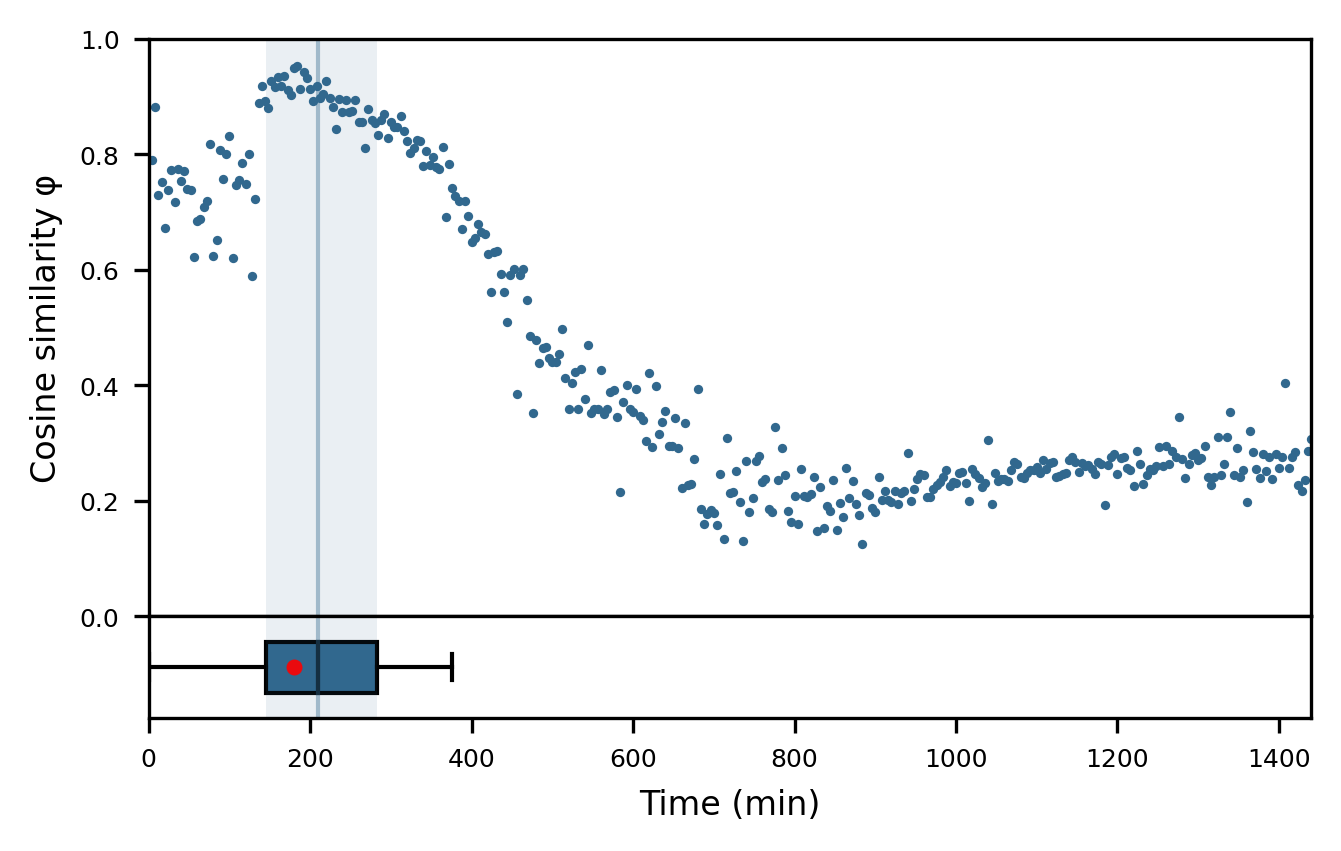

In [16]:
index_image_test = 40
tools_plot.plot_similarity_curve(similarities_test[index_image_test],
                                 path_save=f"{path_dst}/demo_similarity_curve_index40.svg")

## Plot similarities as developmental trajectory <a class="anchor" id="eigth-bullet"></a>

Instead of plotting similarities for one image, in this approach we plot similarities for multiple images. First, we get the maxima of the similarity curves of multiple images, i.e., the predicted developmental stage.

In [17]:
sims_mean = list()

for _k, _v_sims in similarities_test.items():
    sims_mean.append(_v_sims.mean(axis=1))
    
df_sims_mean = pd.DataFrame(sims_mean).reset_index(drop=True)

Second, we plot the maxima of the similarity curves according to the known order of the test image sequence. If the true timepoints are known for the test image sequence, these can be passed as keyword argument ('true_values'). The time intervals of the time series images of the test embryo (intervals_x) and the reference embryos (intervals_y) can also be passed as keyword arguments.

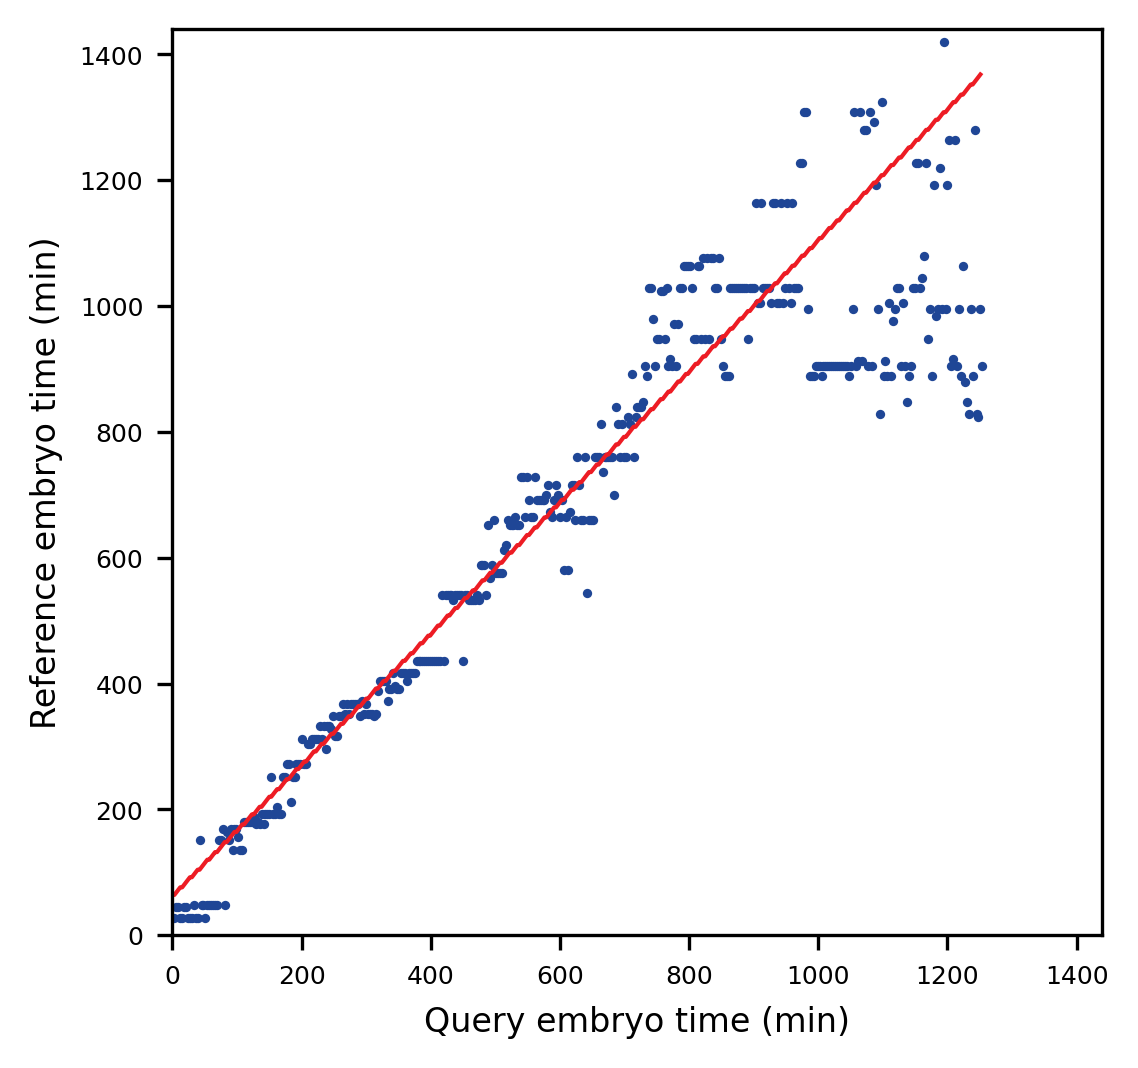

In [18]:
# Based on starting time and time intervals retrieved from image timestamps
true_values_test = [int(i * 187.62589928057554 / 60 / 4 + 16) for i in range(418)]

tools_plot.plot_similarity_maxima(df_sims_mean,
                                  intervals_x=187.62589928057554 / 60,
                                  true_values=true_values_test,
                                  path_save=f"{path_dst}/demo_similarity_maxima_developmental_trajectory.svg")

## Compare similarities of embryos at different acquisition timepoints <a class="anchor" id="ninth-bullet"></a>

Compare two different similarity curves at different timepoints of a test image time series with each other by subtracting the similarity values of two curves.

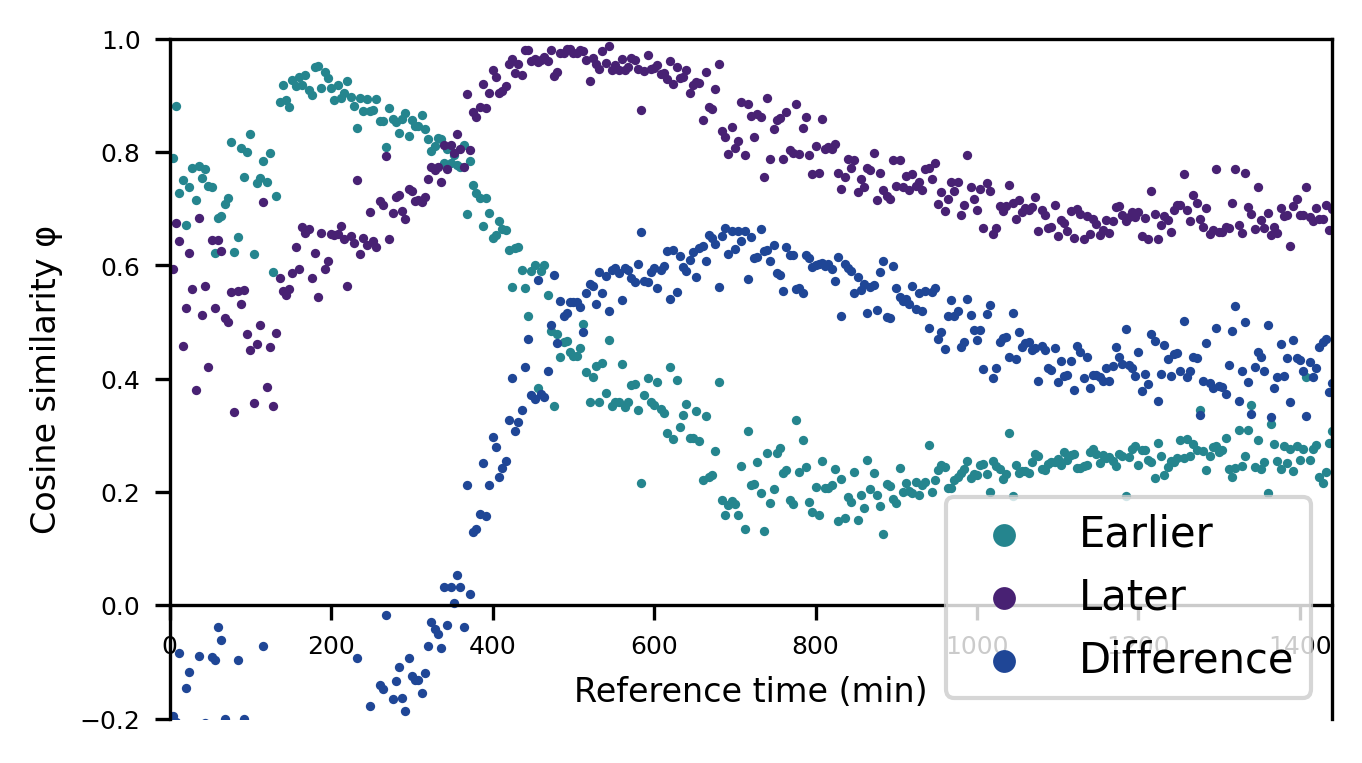

In [19]:
index_image_test_earlier = 40
index_image_test_later = 140

tools_plot.plot_similarity_differences(similarities_test[index_image_test_earlier],
                                       similarities_test[index_image_test_later],
                                       path_save=f"{path_dst}/demo_similarity_differences_indices040vs140.svg")

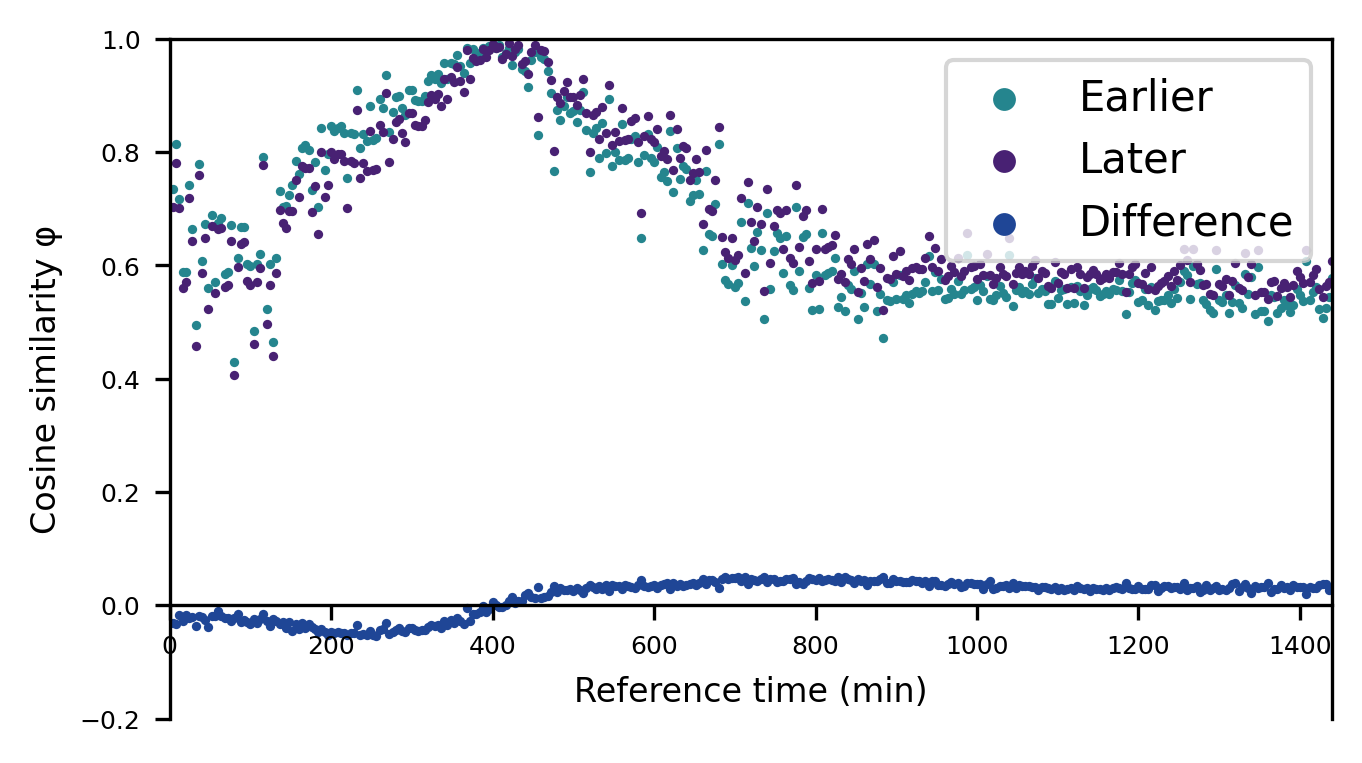

In [20]:
index_image_test_earlier = 120
index_image_test_later = 121

tools_plot.plot_similarity_differences(similarities_test[index_image_test_earlier],
                                       similarities_test[index_image_test_later],
                                       path_save=f"{path_dst}/demo_similarity_differences_indices120vs121.svg")